In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 50 (delta 24), reused 17 (delta 7), pack-reused 0
Receiving objects: 100% (50/50), 209.36 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
from earlystop import Earlystop

In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [40]:
batch_size = 32
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/validation', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [39]:
1600/64

25.0

In [8]:
def ConvBlock(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

In [110]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(

            ConvBlock(3, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
            
            ConvBlock(64, 128),
            nn.MaxPool2d(2,2),
            
            ConvBlock(128, 128),
            ConvBlock(128, 512),
            nn.MaxPool2d(2,2),
            
            ConvBlock(512, 512),
            nn.MaxPool2d(2,2),
        
        )
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512,output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [56]:
model = CNNpenyakitPadi(len(train_set.classes))
model

CNNpenyakitPadi(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2,

In [57]:
from tqdm import tqdm

In [58]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [59]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)

        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stop = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

Test: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 1: train_loss=1.6741, val_loss=1.6158, train_score=0.4183, val_score=0.4015


Test: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 2: train_loss=1.5032, val_loss=1.4468, train_score=0.5964, val_score=0.6439


Test: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 3: train_loss=1.4066, val_loss=1.3810, train_score=0.6759, val_score=0.7020


Test: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 4: train_loss=1.3595, val_loss=1.3481, train_score=0.7119, val_score=0.7172


Test: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 5: train_loss=1.3353, val_loss=1.3352, train_score=0.7320, val_score=0.7298


Test: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 6: train_loss=1.3202, val_loss=1.3216, train_score=0.7402, val_score=0.7374


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 7: train_loss=1.3133, val_loss=1.3027, train_score=0.7500, val_score=0.7601


Test: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Epoch 8: train_loss=1.2991, val_loss=1.2922, train_score=0.7598, val_score=0.7828


Test: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 9: train_loss=1.2932, val_loss=1.2819, train_score=0.7729, val_score=0.7929


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 10: train_loss=1.2856, val_loss=1.2725, train_score=0.7810, val_score=0.8005


Test: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 11: train_loss=1.2723, val_loss=1.2631, train_score=0.7941, val_score=0.8106


Test: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch 12: train_loss=1.2639, val_loss=1.2504, train_score=0.8023, val_score=0.8232


Test: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


Epoch 13: train_loss=1.2541, val_loss=1.2464, train_score=0.8148, val_score=0.8232


Test: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Epoch 14: train_loss=1.2448, val_loss=1.2411, train_score=0.8197, val_score=0.8182


Test: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Epoch 15: train_loss=1.2433, val_loss=1.2373, train_score=0.8175, val_score=0.8182


Test: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 16: train_loss=1.2425, val_loss=1.2329, train_score=0.8181, val_score=0.8308


Test: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Epoch 17: train_loss=1.2328, val_loss=1.2277, train_score=0.8301, val_score=0.8333


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 18: train_loss=1.2328, val_loss=1.2218, train_score=0.8268, val_score=0.8384


Test: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


Epoch 19: train_loss=1.2233, val_loss=1.2194, train_score=0.8399, val_score=0.8359


Test: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 20: train_loss=1.2172, val_loss=1.2254, train_score=0.8469, val_score=0.8434
EarlyStop patience =  1. Best test_cost: 1.2194


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 21: train_loss=1.2099, val_loss=1.2123, train_score=0.8524, val_score=0.8434


Test: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Epoch 22: train_loss=1.2158, val_loss=1.2117, train_score=0.8459, val_score=0.8434


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 23: train_loss=1.2080, val_loss=1.2127, train_score=0.8508, val_score=0.8384
EarlyStop patience =  1. Best test_cost: 1.2117


Test: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 24: train_loss=1.1956, val_loss=1.2085, train_score=0.8644, val_score=0.8535


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 25: train_loss=1.1955, val_loss=1.2044, train_score=0.8617, val_score=0.8434


Test: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


Epoch 26: train_loss=1.1829, val_loss=1.1909, train_score=0.8780, val_score=0.8737


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 27: train_loss=1.1772, val_loss=1.1853, train_score=0.8851, val_score=0.8687


Test: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 28: train_loss=1.1813, val_loss=1.1783, train_score=0.8802, val_score=0.8813


Test: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 29: train_loss=1.1699, val_loss=1.1812, train_score=0.8943, val_score=0.8763
EarlyStop patience =  1. Best test_cost: 1.1783


Test: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


Epoch 30: train_loss=1.1732, val_loss=1.1830, train_score=0.8851, val_score=0.8763
EarlyStop patience =  2. Best test_cost: 1.1783
Training early stopped. tidak ada peningkatan pada 2 epoch terakhir atau mencapai target score.
Early Stopping pada epoch: 29 | Best test_cost: 1.1783


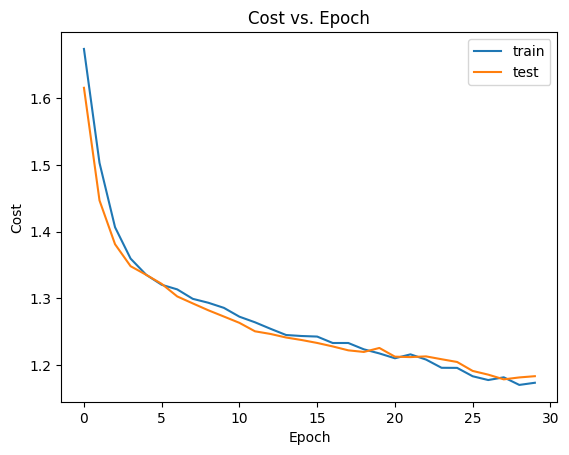

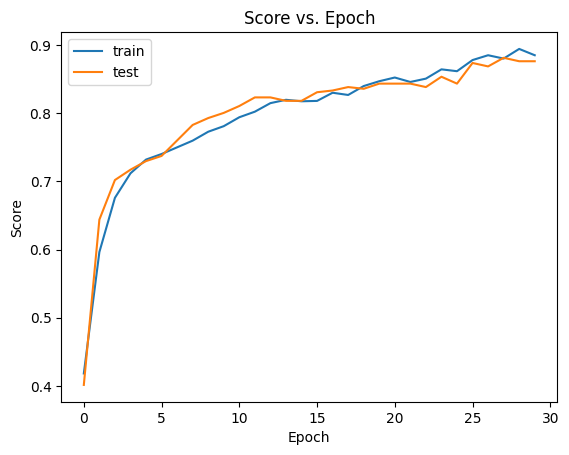

In [61]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, early_stop, epoch)

In [80]:
!pip install torchsummary

In [112]:
test_transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test', transform=test_transform)
testloader = DataLoader(test_set, batch_size, shuffle=False)

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [114]:
def eval_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [115]:
eval_model(model, testloader, criterion, device)

Test Loss: 1.1407, Test Accuracy: 0.9217


In [104]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.1407, Test Accuracy: 0.9217
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       0.86      0.91      0.88        66
           2       0.83      0.94      0.88        66
           3       0.91      0.74      0.82        66
           4       1.00      0.94      0.97        66
           5       0.96      1.00      0.98        66

    accuracy                           0.92       396
   macro avg       0.92      0.92      0.92       396
weighted avg       0.92      0.92      0.92       396

Confusion Matrix:


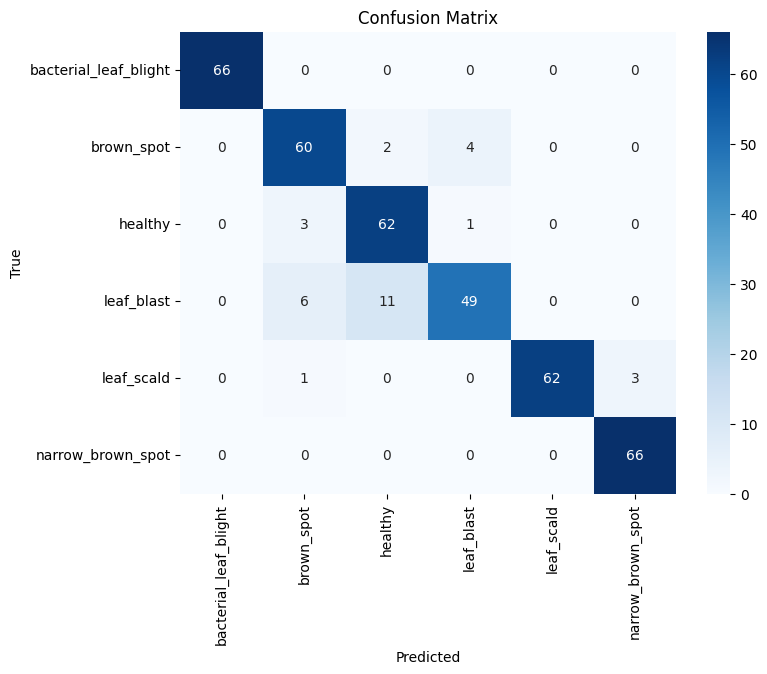

In [105]:
evaluate_model(model, testloader, criterion, device)

In [82]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              30
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              ReLU-3          [-1, 3, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]             128
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]             320
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]           2,112
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

early_stop.reset_early_stop()
early_stop.early_stop_patience = 5
epoch = 30

In [ ]:
fit(train_set, trainloader, test_set, testloader, model, criterion, optimizer, device, early_stop, epoch)

In [75]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook


model.feature[2][0].register_forward_hook(get_activation('onv2'))
model.feature[2][3].register_forward_hook(get_activation('conv3'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))
model.feature[4][3].register_forward_hook(get_activation('conv5'))


model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[2][5].register_forward_hook(get_activation('relu4'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))
model.feature[4][5].register_forward_hook(get_activation('relu6'))


img = Image.open('/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test/brown_spot/brown_val (53).jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(230)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

output = model(img_tensor)

/tmp/ipykernel_32/998774735.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


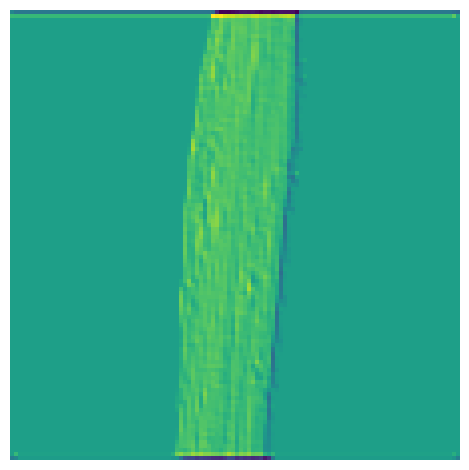

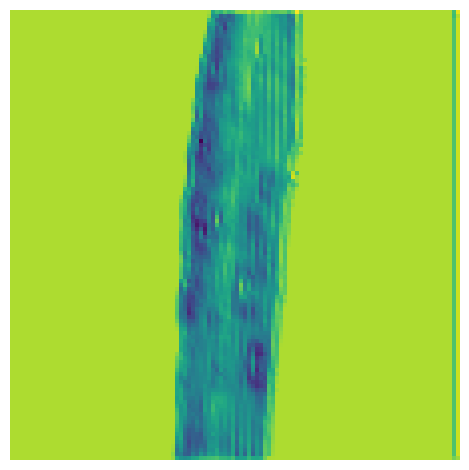

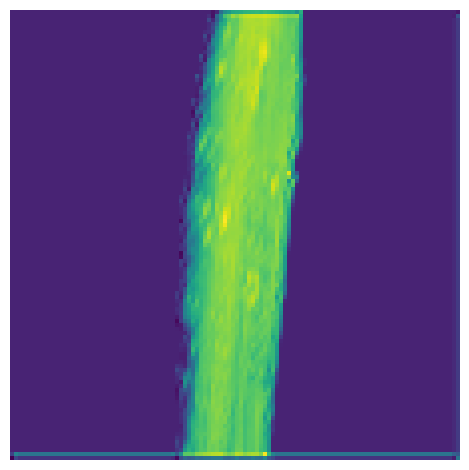

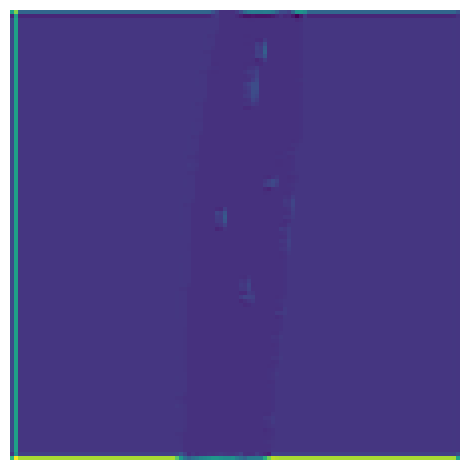

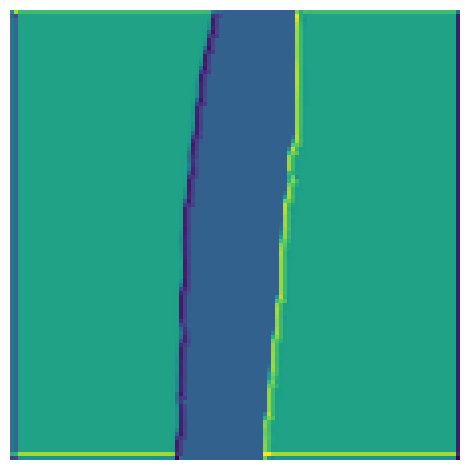

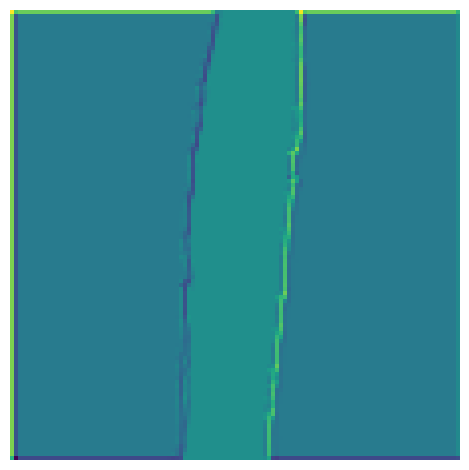

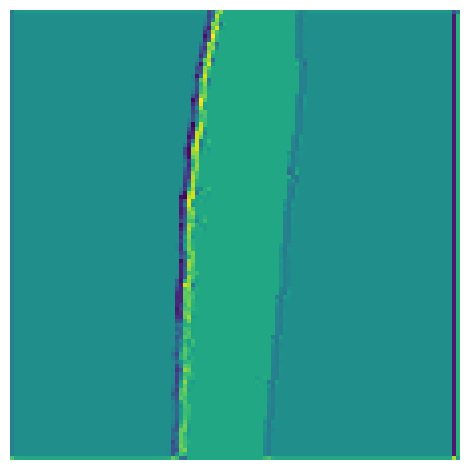

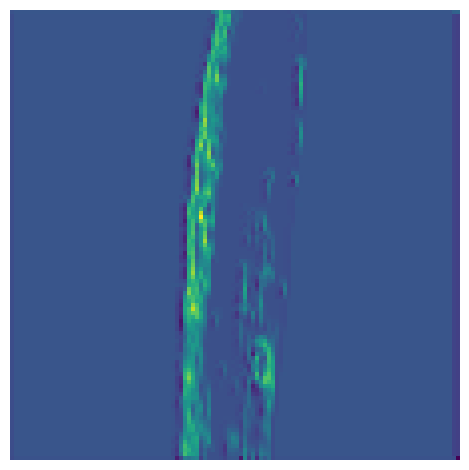

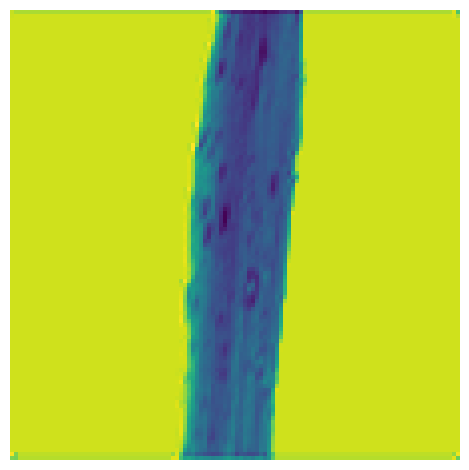

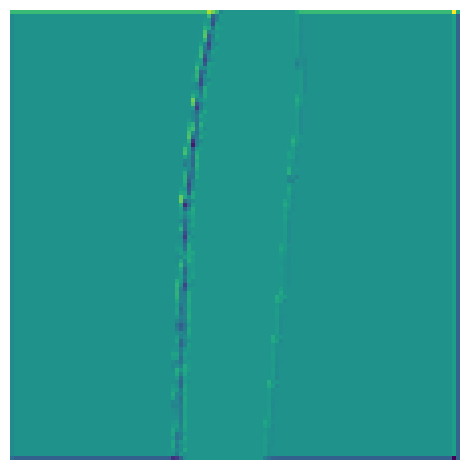

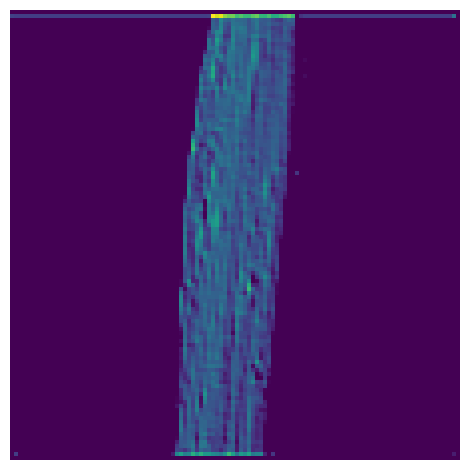

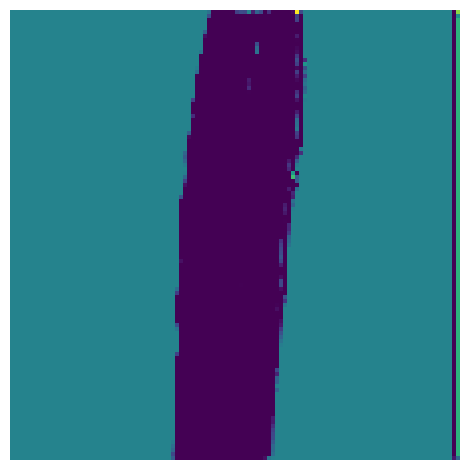

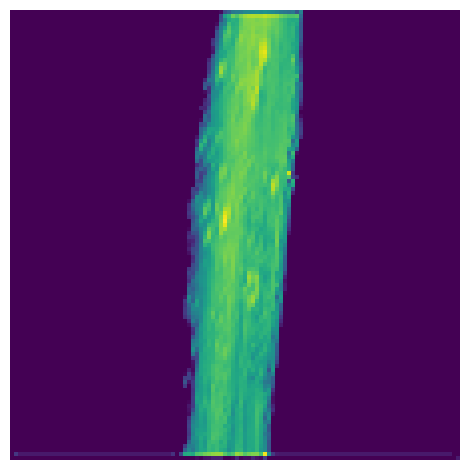

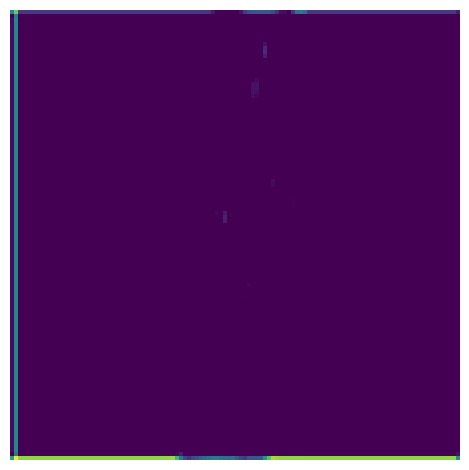

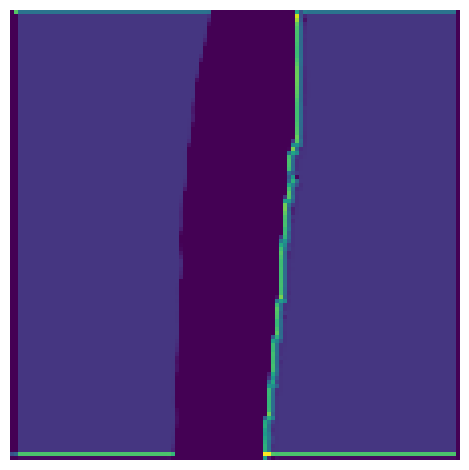

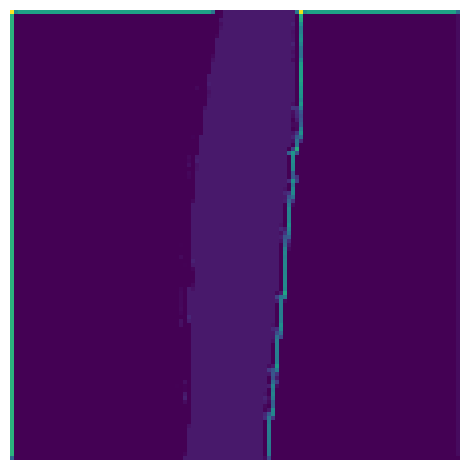

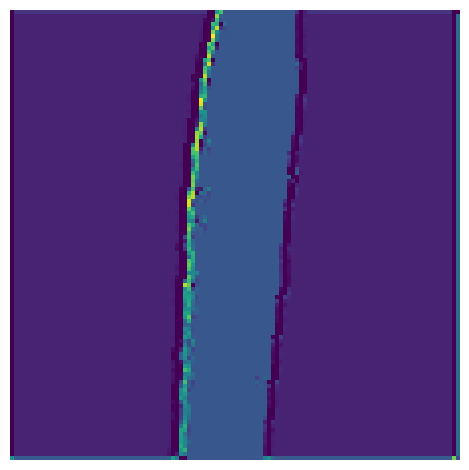

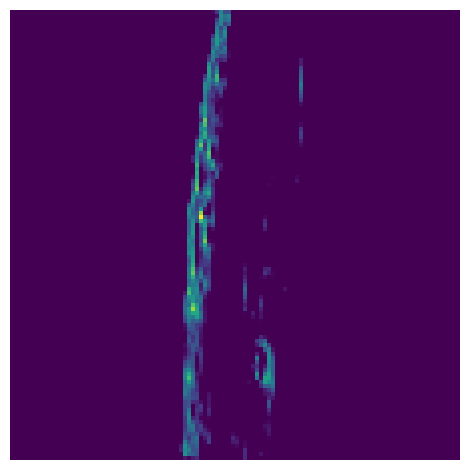

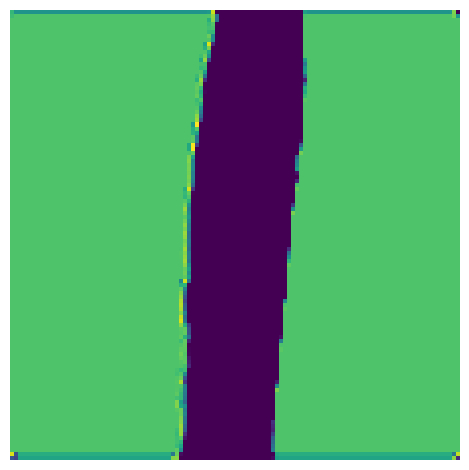

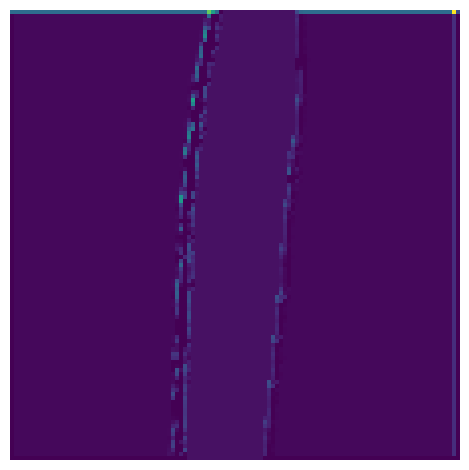

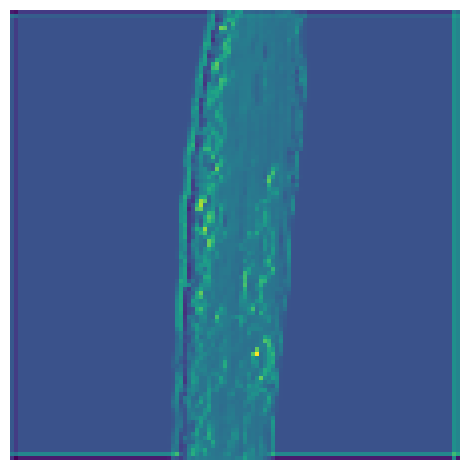

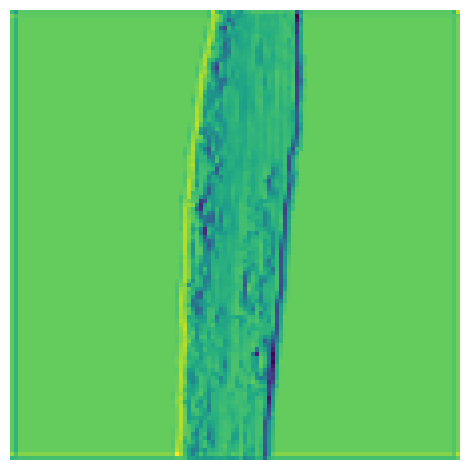

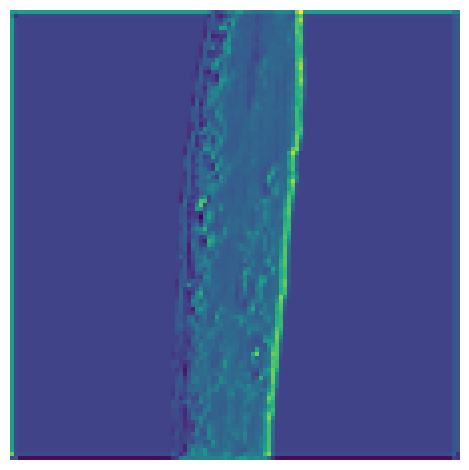

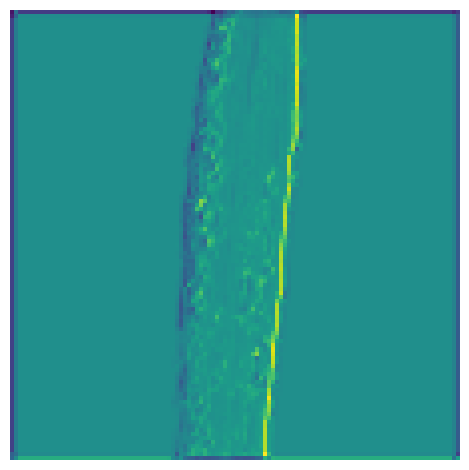

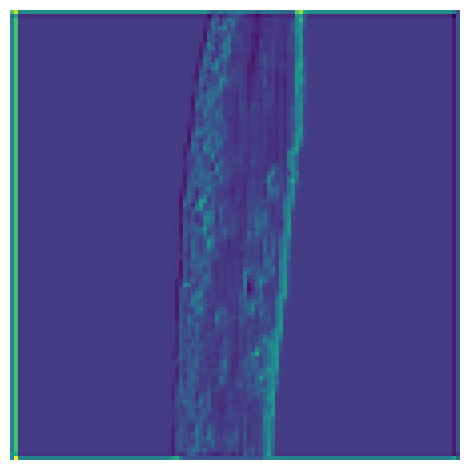

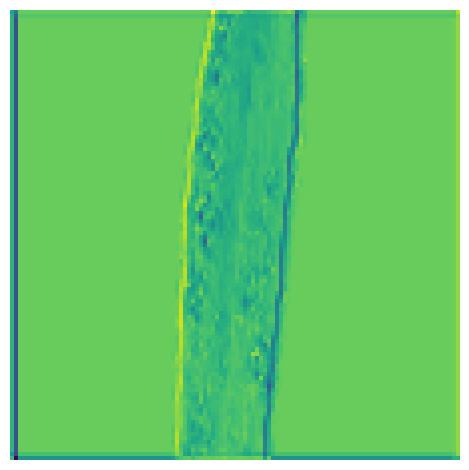

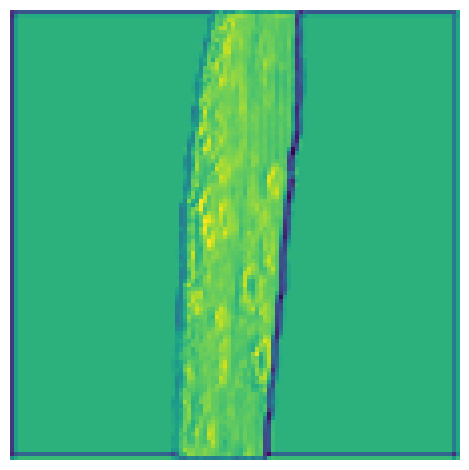

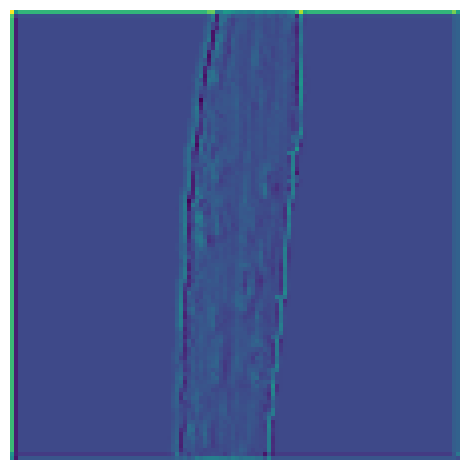

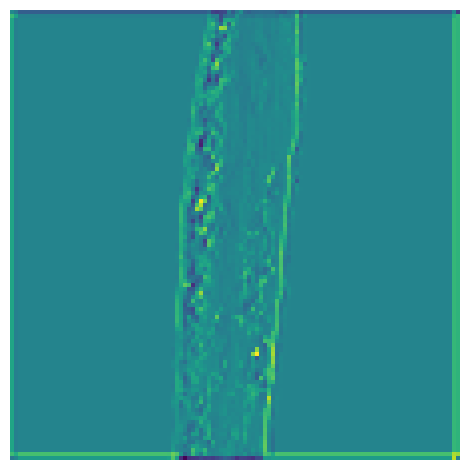

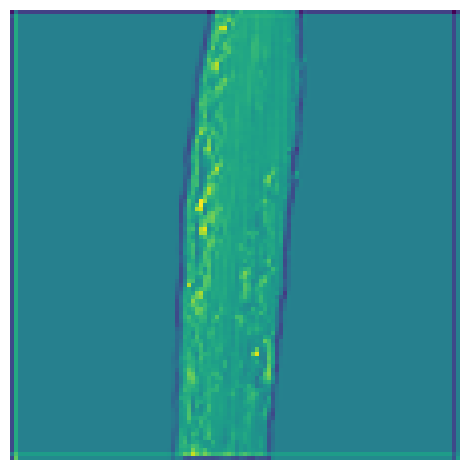

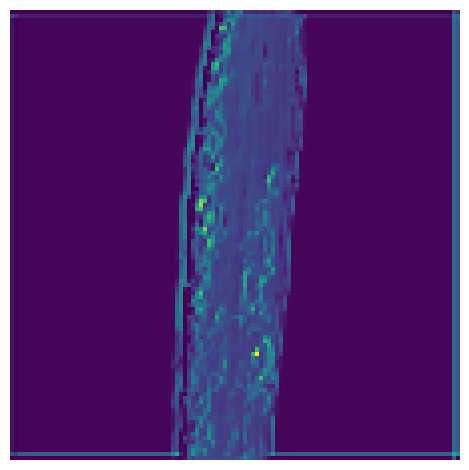

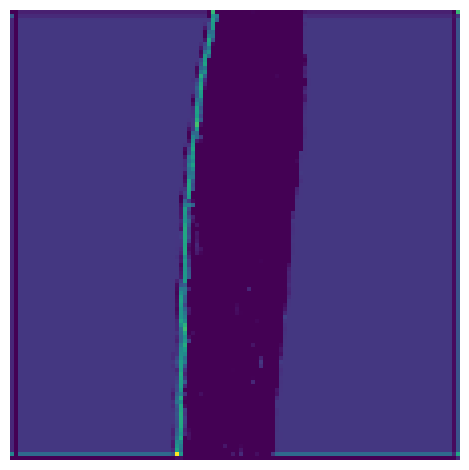

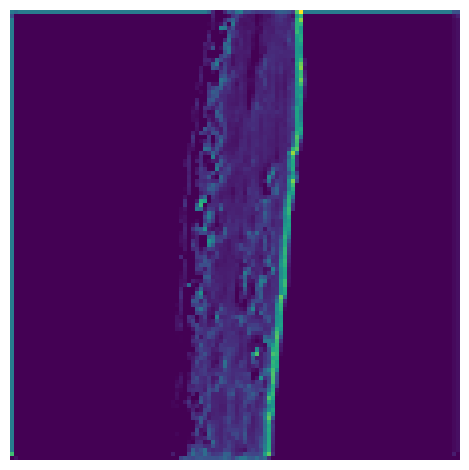

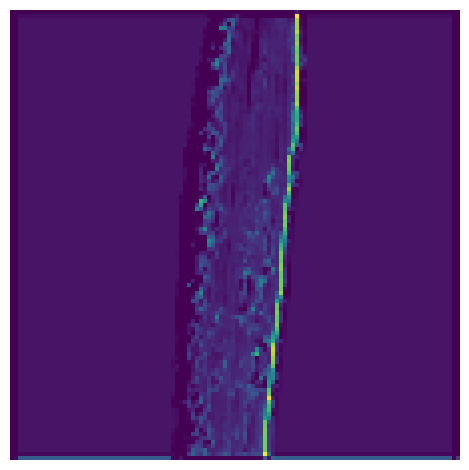

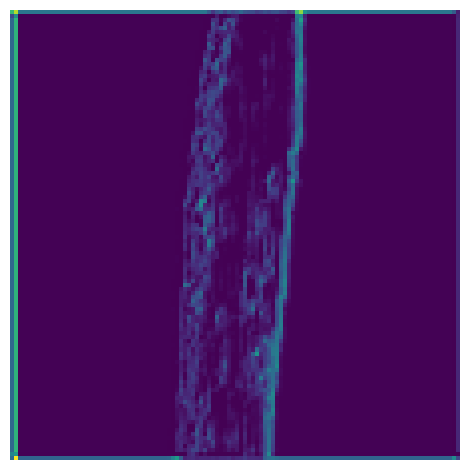

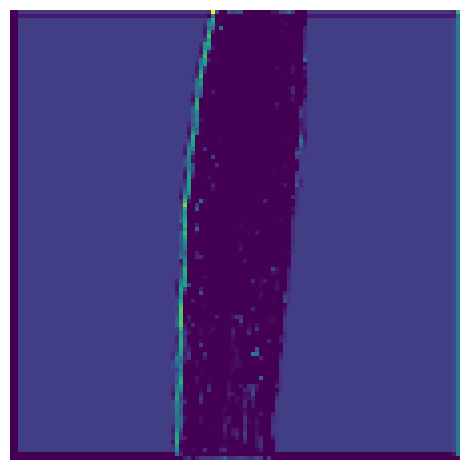

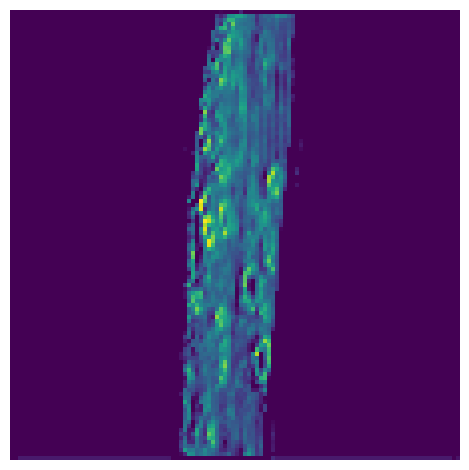

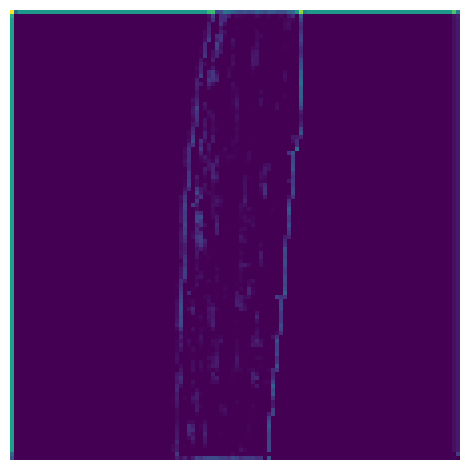

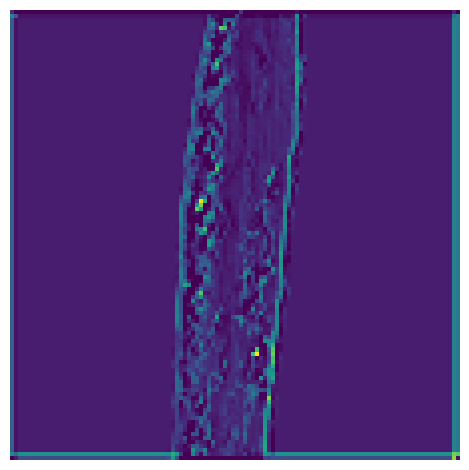

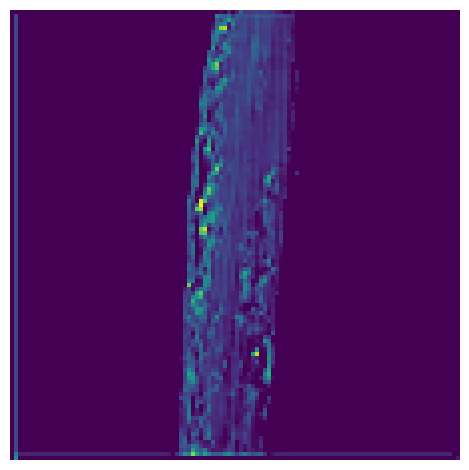

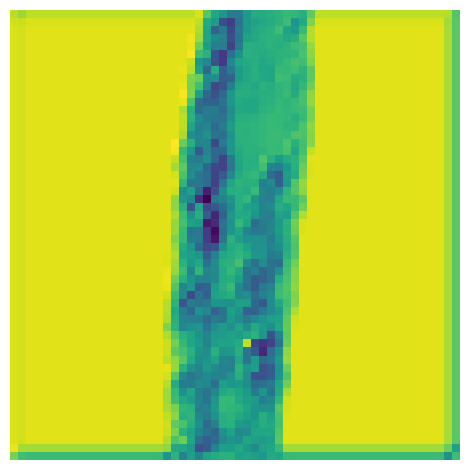

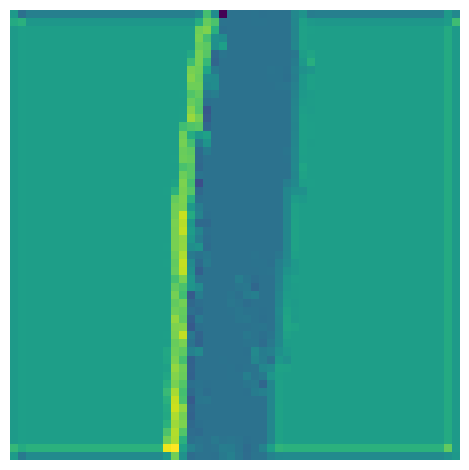

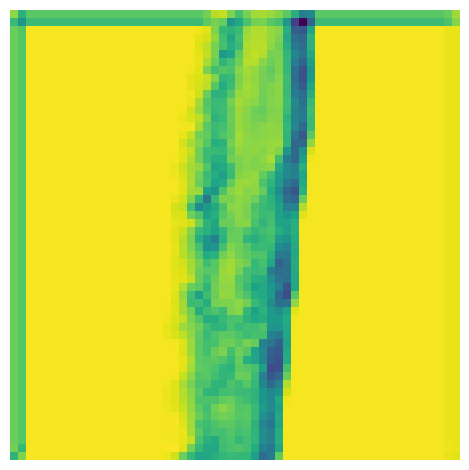

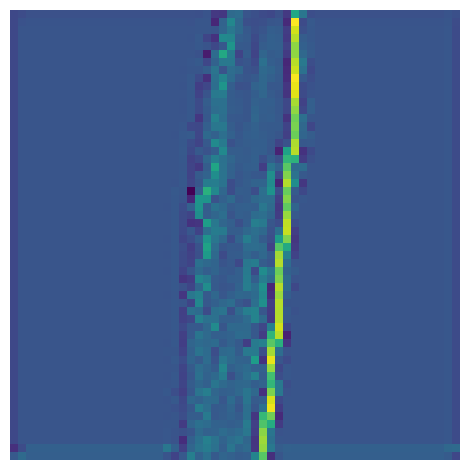

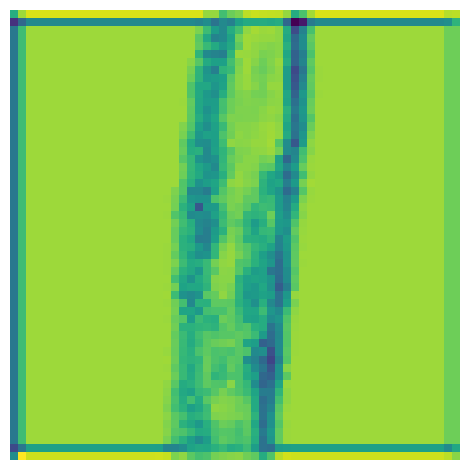

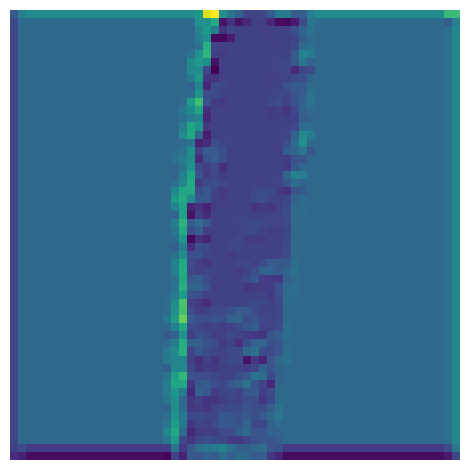

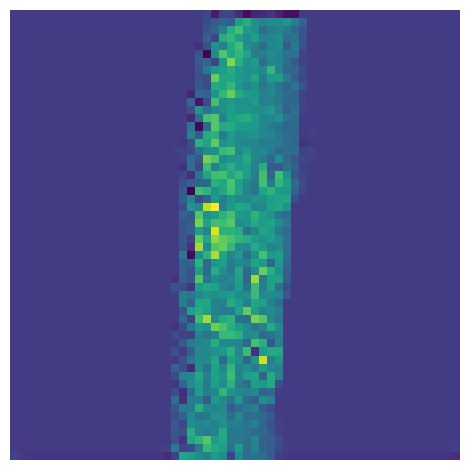

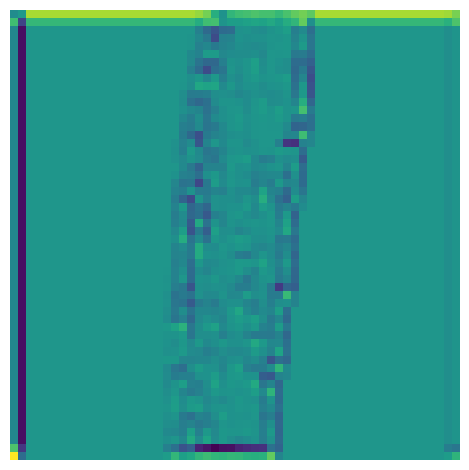

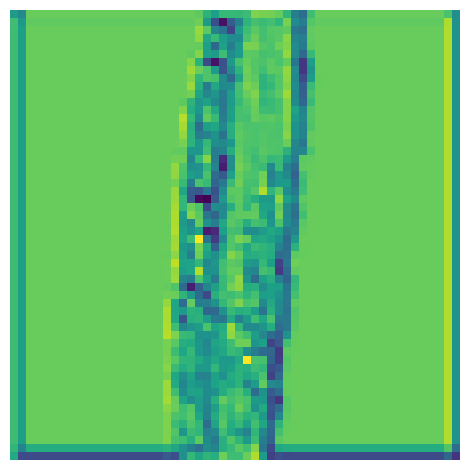

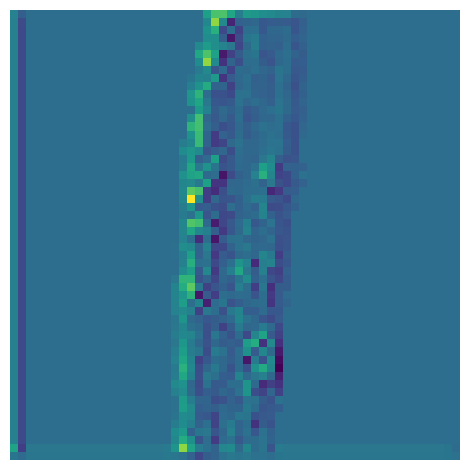

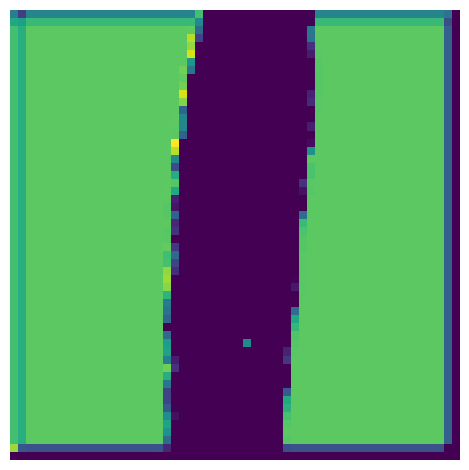

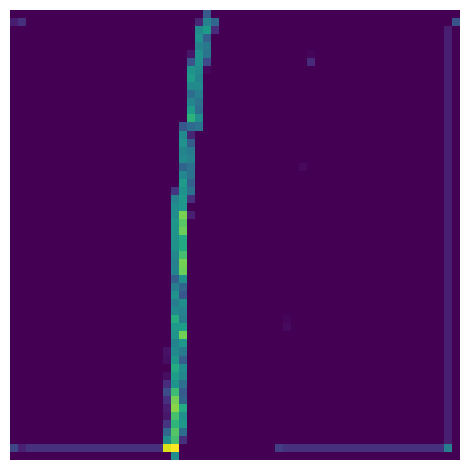

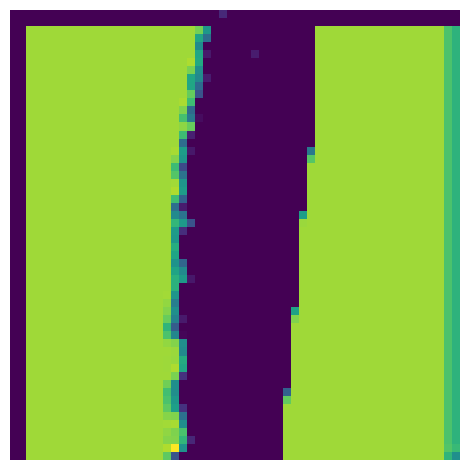

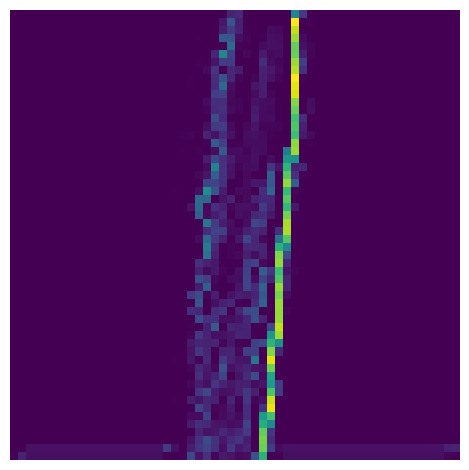

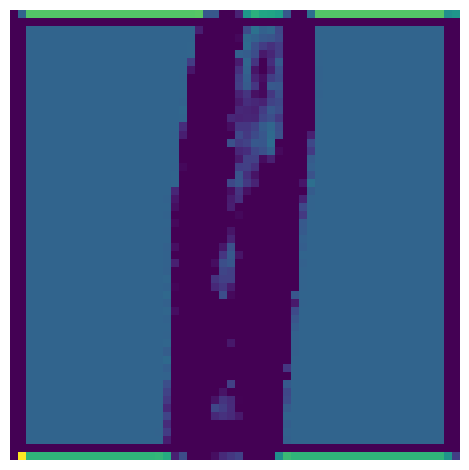

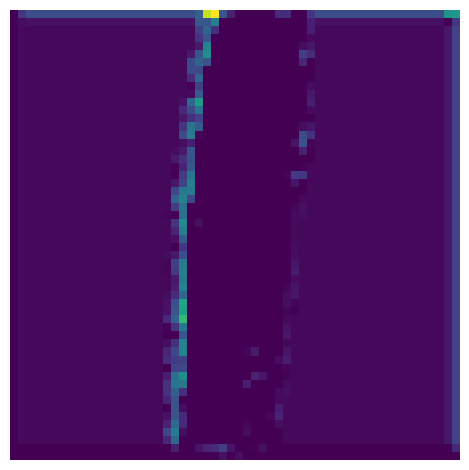

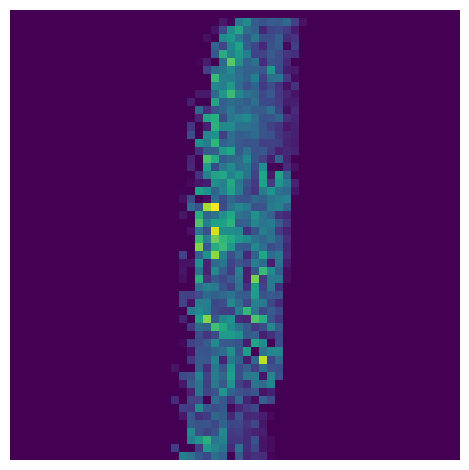

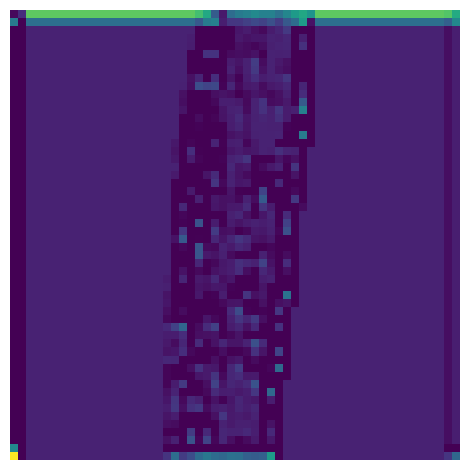

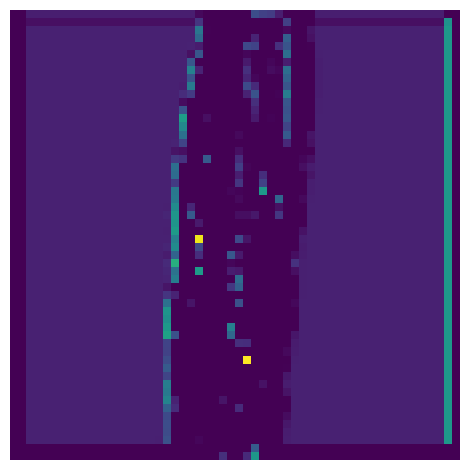

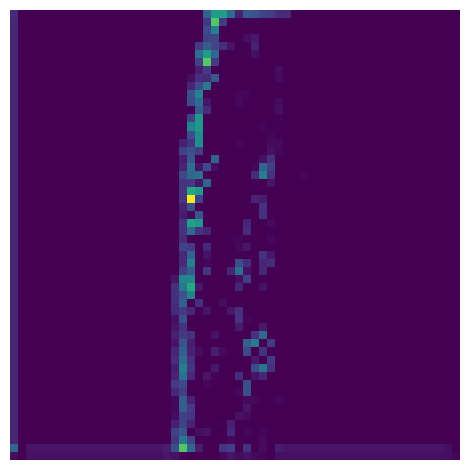

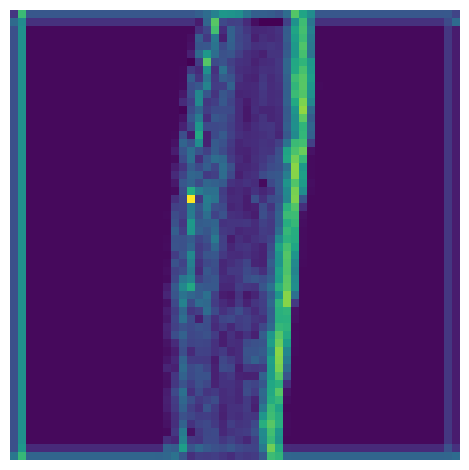

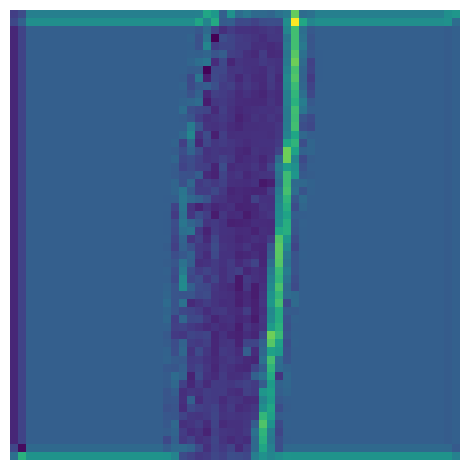

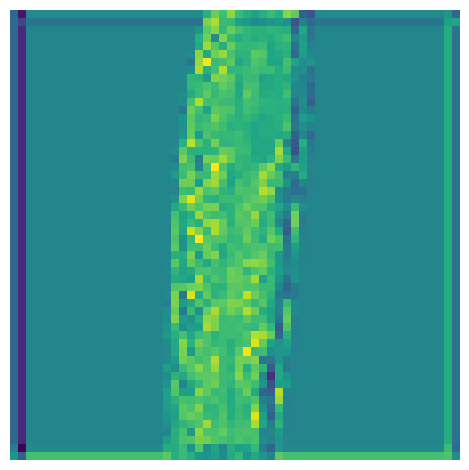

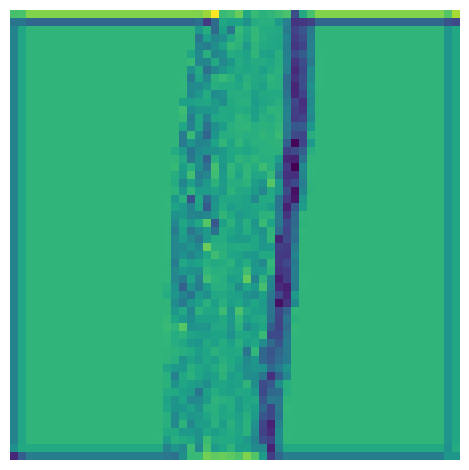

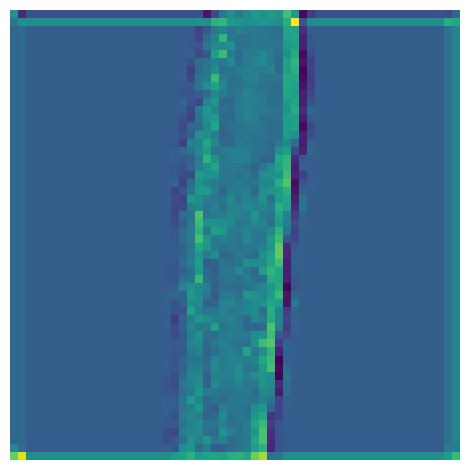

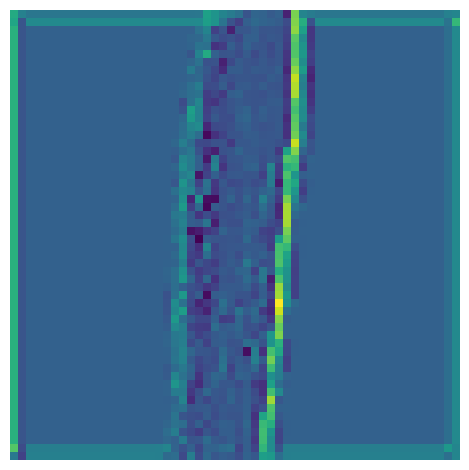

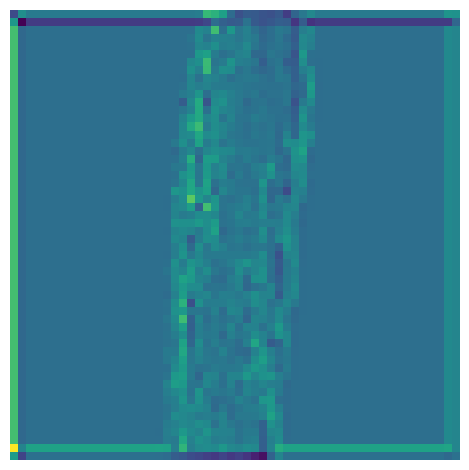

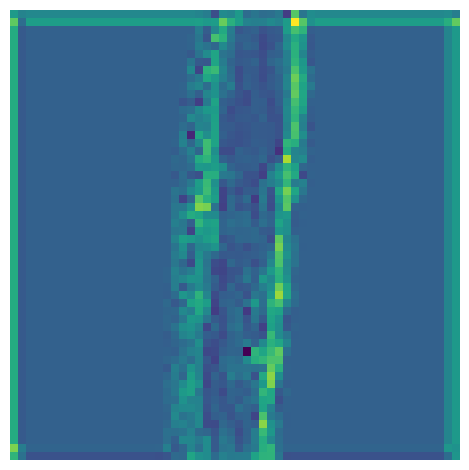

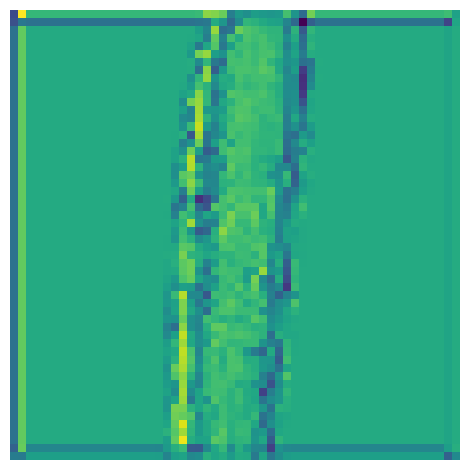

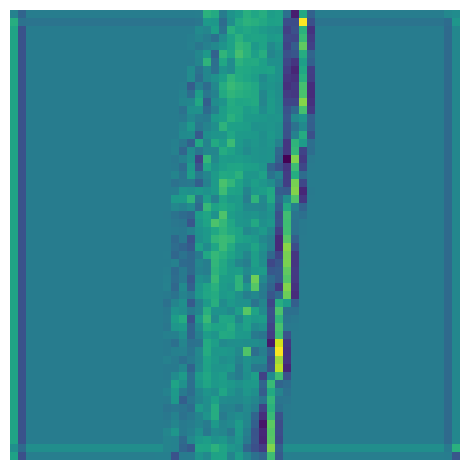

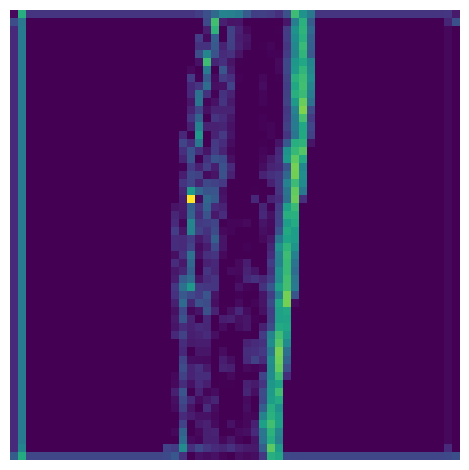

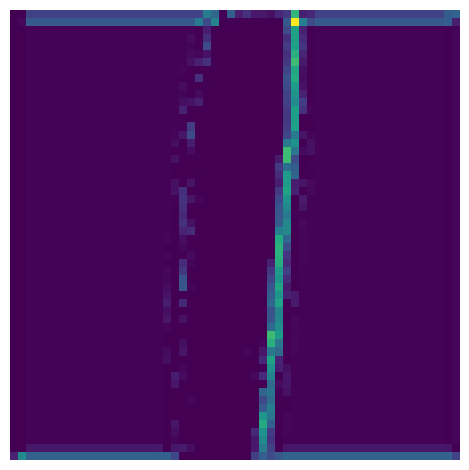

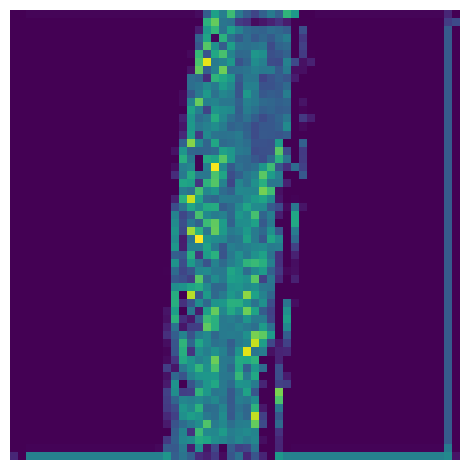

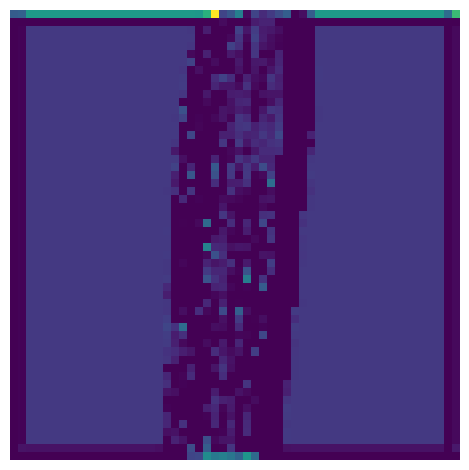

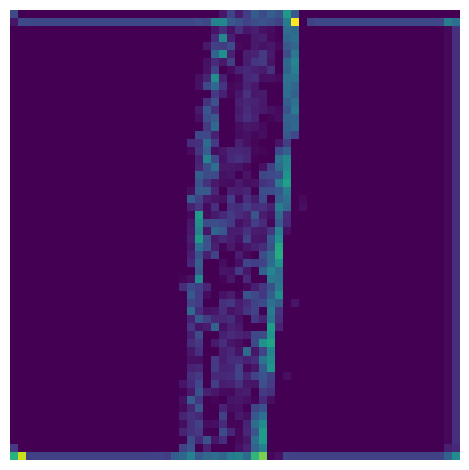

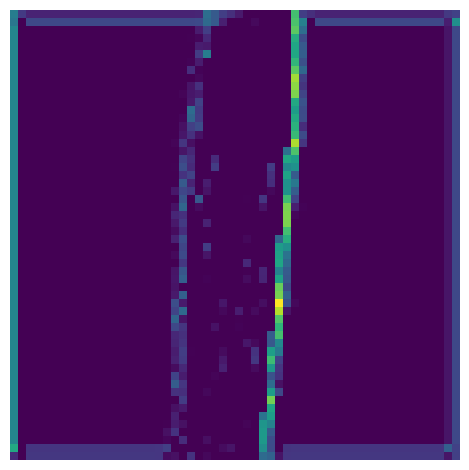

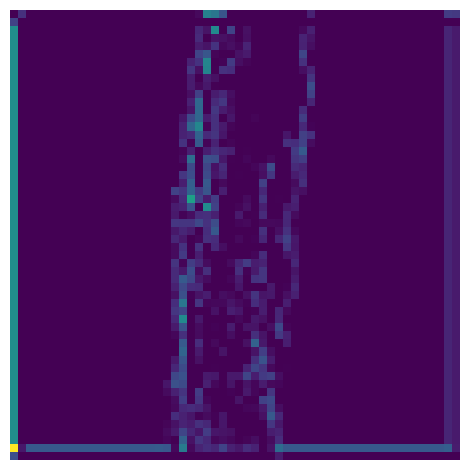

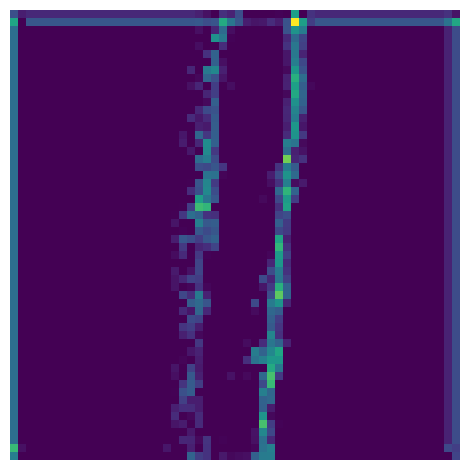

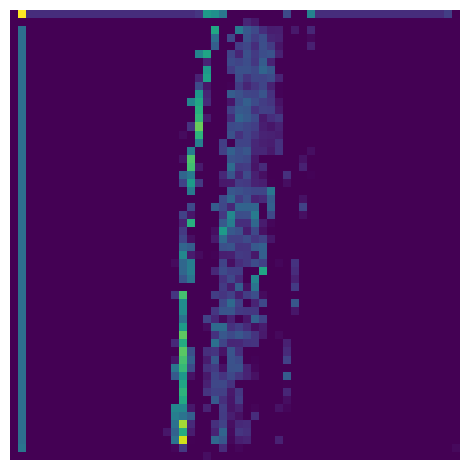

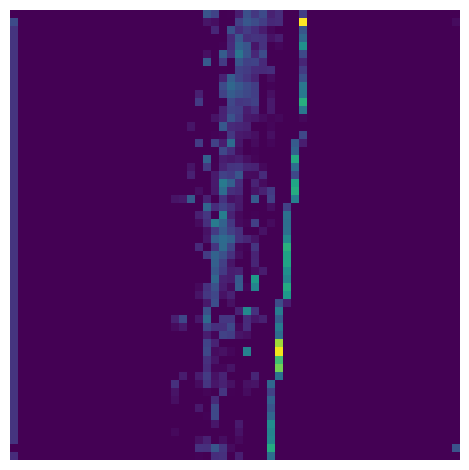

In [77]:
activation_names = list(activation1.keys())

for name in activation_names:
    folder_path = os.path.join('custom_img004copy', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i in range(10):
        fig, ax = plt.subplots(1, 1)
        ax.imshow(activation1[file][0, i].cpu().numpy())
        ax.axis('off')
        plt.tight_layout()
        
        fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)

In [ ]:
folder_path = 'custom_img003copy'
file = 'relu6'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)


subfolder_name = file

new_folder_path = os.path.join(folder_path, subfolder_name)

if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(activation[file][0, i].cpu().numpy())
    ax.axis('off')
    plt.tight_layout()
    
    fig.savefig(f'{new_folder_path}/{file}-{i}.png', dpi=300, transparent=True)

tensor([[[[1.0000, 1.0000, 0.8549, 0.6392, 0.9765, 1.0000],
          [1.0000, 1.0000, 0.8078, 0.6471, 0.9804, 1.0000],
          [1.0000, 1.0000, 0.7686, 0.6863, 0.9882, 1.0000],
          [1.0000, 0.9961, 0.7529, 0.7333, 0.9961, 1.0000],
          [1.0000, 0.9961, 0.7490, 0.7922, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.7412, 0.8235, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.8863, 0.7451, 0.9843, 1.0000],
          [1.0000, 1.0000, 0.8549, 0.7647, 0.9882, 1.0000],
          [1.0000, 1.0000, 0.8118, 0.7686, 0.9922, 1.0000],
          [1.0000, 1.0000, 0.8078, 0.7922, 0.9961, 1.0000],
          [1.0000, 0.9961, 0.8235, 0.8392, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.8353, 0.8824, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.7294, 0.4157, 0.9569, 1.0000],
          [1.0000, 1.0000, 0.6353, 0.4275, 0.9647, 1.0000],
          [1.0000, 0.9961, 0.5569, 0.4706, 0.9804, 1.0000],
          [1.0000, 0.9922, 0.5333, 0.5294, 0.9922, 1.0000],
          [1.0000, 0.9882, 0.5255, 0

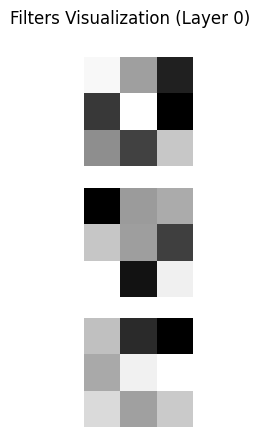

bias :tensor([-0.2482, -0.2195, -0.0180])


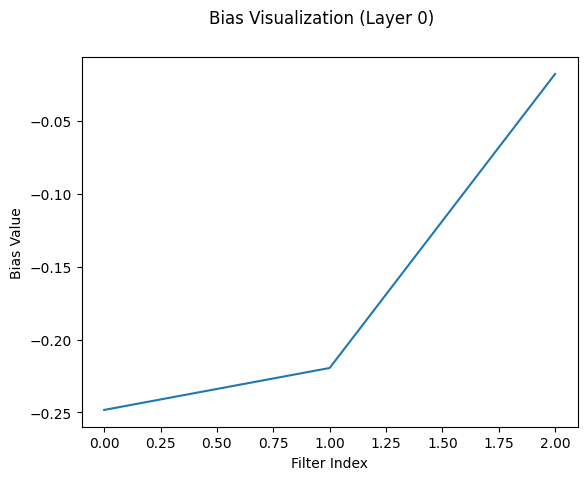

fitur :tensor([[[[-0.2794, -0.4248, -0.3933, -0.4611, -0.3859, -0.2780],
          [-0.4520, -0.2888, -0.2281, -0.4188, -0.3906,  0.0419],
          [-0.4526, -0.2673, -0.2466, -0.4224, -0.3934,  0.0417],
          [-0.4514, -0.2550, -0.2669, -0.4272, -0.3883,  0.0424],
          [-0.4504, -0.2516, -0.2933, -0.4192, -0.3842,  0.0438],
          [-0.4457, -0.2249, -0.3484, -0.4454, -0.3860,  0.1820]],

         [[-0.2747,  0.1561,  0.1799,  0.1548,  0.0695,  0.0555],
          [-0.1084,  0.0200,  0.0353,  0.0341,  0.0266, -0.1566],
          [-0.1084,  0.0219,  0.0385,  0.0316,  0.0281, -0.1560],
          [-0.1094,  0.0232,  0.0396,  0.0391,  0.0441, -0.1553],
          [-0.1088,  0.0233,  0.0438,  0.0405,  0.0580, -0.1558],
          [-0.1213, -0.2399, -0.2676, -0.2404, -0.2181, -0.2043]],

         [[ 0.9019,  1.1301,  0.8686,  0.9025,  1.0484,  0.7630],
          [ 0.6704,  1.0850,  0.9128,  0.8440,  0.9160,  0.8714],
          [ 0.6684,  1.0692,  0.9172,  0.8338,  0.9438,  0.8780],

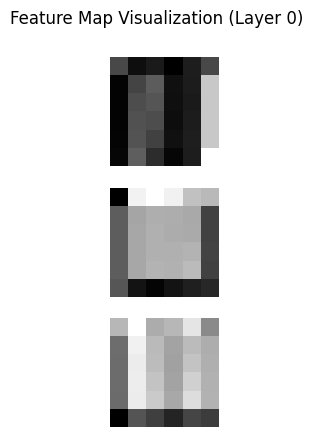

relu :tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0419],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0417],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0424],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0438],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1820]],

         [[0.0000, 0.1561, 0.1799, 0.1548, 0.0695, 0.0555],
          [0.0000, 0.0200, 0.0353, 0.0341, 0.0266, 0.0000],
          [0.0000, 0.0219, 0.0385, 0.0316, 0.0281, 0.0000],
          [0.0000, 0.0232, 0.0396, 0.0391, 0.0441, 0.0000],
          [0.0000, 0.0233, 0.0438, 0.0405, 0.0580, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.9019, 1.1301, 0.8686, 0.9025, 1.0484, 0.7630],
          [0.6704, 1.0850, 0.9128, 0.8440, 0.9160, 0.8714],
          [0.6684, 1.0692, 0.9172, 0.8338, 0.9438, 0.8780],
          [0.6670, 1.0711, 0.9401, 0.8392, 0.9815, 0.8846],
          [0.6656, 1.0686, 0.9

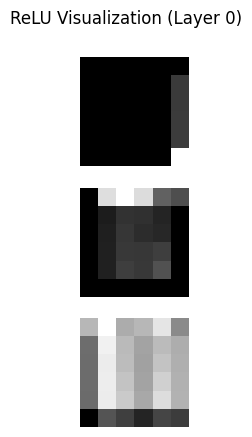

In [106]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/dataset-rice-leaf/RiceLeafsDisease/test/brown_spot/brown_val (53).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)